# Importing Necessary Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

rs = 42 # Defining random state

import re
import string
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer

## Reading the dataset

In [2]:
df = pd.read_csv("Disaster_tweets.csv")
df = df[["text", "target"]]
df.head()

,text,target
0,Our Deeds are the Reason of this #earthquake M...,1
1,Forest fire near La Ronge Sask. Canada,1
2,All residents asked to 'shelter in place' are ...,1
3,"13,000 people receive #wildfires evacuation or...",1
4,Just got sent this photo from Ruby #Alaska as ...,1


In [3]:
# Checking dataframe shape
df.shape

(7613, 2)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    7613 non-null   object
 1   target  7613 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 119.1+ KB


## Preprocessing text

In [5]:
def preprocess(sentences):
    tweet_list = []
    filter = string.ascii_letters + " "
    lm = WordNetLemmatizer()
    for tweet in sentences:
        tweet_cleaned = re.sub(r'http\S+', '', tweet)                                         # remove url
        tweet_cleaned = "".join([chr for chr in tweet_cleaned if chr in filter])              # remove punctuation
        tweet_cleaned = tweet_cleaned.lower()                                                 # convert to lower case
        tokens = word_tokenize(tweet_cleaned)                                                 # tokenize
        clean_list = [word for word in tokens if word not in stopwords.words('english')]      # removing stopwords
        clean_list = [lm.lemmatize(word) for word in clean_list]                              # lemmatizing
        tweet_cleaned = " ".join(clean_list)                                                  # combine tokens back together
        tweet_list.append(tweet_cleaned)

    return np.array(tweet_list)

In [6]:
df["text"] = preprocess(df["text"])

In [7]:
df.head()

,text,target
0,deed reason earthquake may allah forgive u,1
1,forest fire near la ronge sask canada,1
2,resident asked shelter place notified officer ...,1
3,people receive wildfire evacuation order calif...,1
4,got sent photo ruby alaska smoke wildfire pour...,1


In [8]:
# Dropping Duplicates
df.drop_duplicates(inplace = True)

# Splitting dataset into train and test sets

In [9]:
# Splitting Data into train and test
X = df["text"]
y = df["target"]

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=rs)

print(f"shape of X_train: {X_train.shape}")
print(f"shape of X_test: {X_test.shape}")
print(f"shape of y_train: {y_train.shape}")
print(f"shape of y_test: {y_test.shape}")

shape of X_train: (5541,)
shape of X_test: (1386,)
shape of y_train: (5541,)
shape of y_test: (1386,)


In [10]:
vocab = []

for tweet in X_train:
    tweet_words = tweet.split()
    vocab.extend(tweet_words)
    
print(f"Number of unique words in X_train = {len(set(vocab))}")

Number of unique words in X_train = 13544


## Text Vectorization (Tokenization Using Tensorflow)
- this is similar to vectorizing text using sklearn (BOW, tf-idf, ohe)

In [13]:
import tensorflow as tf
from tensorflow.keras.layers import TextVectorization

vectorizer = TextVectorization(max_tokens = None,                             # Number of words in vocabulary
                               standardize = 'lower_and_strip_punctuation',   # How to process text
                               split = 'whitespace',                          # How to split tokens from document
                               ngrams = None,                                 # Define n-grams size if necessary
                               output_mode = 'int',                           # How to map tokens to output
                               output_sequence_length = None                  # Determines the maximum length of the output sequences
                               )

# fit the vectorizer on training text
vectorizer.adapt(X_train) 

In [14]:
import random
random_index = random.choice(range(len(X_train)))
tweet = X_train.iloc[random_index]
print(f"tweet: {tweet}")
print(f"Vectorized_tweet: {vectorizer(tweet)}")

tweet: militant attack police post udhampur spos injuredsuspected militant thursday attacked police post
Vectorized_tweet: [1109   52   28  246 1181 1504 9714 1109  845  830   28  246]


##### After vectorizing if we want to apply RNN directly, we need to give a fixed  `output_sequence_length` so the tensor size gets fixed. After that the vectors can be directly passed into RNN or ML algorithms for prediction.

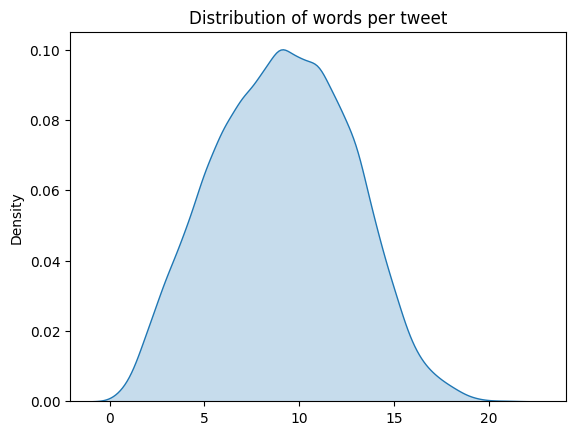

In [15]:
# To decide the value of output_sequence_length, we need to analyze the average length of sentences in our corpus.
# For that we can analyze the kdeplot of number of words per tweet
tokens_per_tweet = [len(tweet.split()) for tweet in X_train]

sns.kdeplot(tokens_per_tweet, fill=True)
plt.title('Distribution of words per tweet')
plt.show()

In [16]:
pd.Series(tokens_per_tweet).describe()
# here we can see that about 75% of our data can be covered if we use output_sequence_length of around 12.
# This is how we choose the output_sequence_length.

count    5541.000000
mean        9.110630
std         3.545913
min         1.000000
25%         6.000000
50%         9.000000
75%        12.000000
max        21.000000
dtype: float64

In [17]:
# get_vocabulary() sorts the words in descending order of frequency of words in the corpus.
# top 5 words are the most common 5 words in the corpus.
# bottom 5 words are the least common 5 words in the corpus.

words_in_vocab = vectorizer.get_vocabulary()
print(f"Number of words in vocabulary = {len(words_in_vocab)}")

top_5_words = words_in_vocab[:5]
print(f"top_5 most commonwords = {top_5_words}")

bottom_5_words = words_in_vocab[-5:]
print(f"Bottom 5 least common words = {bottom_5_words}")

Number of words in vocabulary = 13546
top_5 most commonwords = ['', '[UNK]', 'like', 'fire', 'amp']
Bottom 5 least common words = ['aal', 'aaceorg', 'aaarrrgghhh', 'aaaaaaallll', 'aaaa']


<hr>